In [5]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

import admix
import numpy as np
import pandas as pd
import admix_prs
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
DATA_DIR = "/u/project/pasaniuc/pasaniucdata/admixture/projects/admix-prs-uncertainty/experiments/00-compile-data/out"
PHENO_DIR = "/u/project/sgss/UKBB/PRS-RESEARCH/03-compile-pheno/out"

In [7]:
COVAR_COLS = ["AGE", "SEX", "DEPRIVATION_INDEX"] + [f"PC{i}" for i in range(1, 11)]
TEST_COLS = ["SEX", "glasses"] + [
    col + "_Q"
    for col in ["AGE", "years_of_edu", "income", "DEPRIVATION_INDEX", "PC1", "PC2"]
]
print("Covariates:", ", ".join(COVAR_COLS))
print("Testing:", ", ".join(TEST_COLS))

Covariates: AGE, SEX, DEPRIVATION_INDEX, PC1, PC2, PC3, PC4, PC5, PC6, PC7, PC8, PC9, PC10
Testing: SEX, glasses, AGE_Q, years_of_edu_Q, income_Q, DEPRIVATION_INDEX_Q, PC1_Q, PC2_Q


In [15]:
df_covar = pd.read_csv(os.path.join(DATA_DIR, "covar.tsv"), sep="\t", index_col=0)

# add some phenotype to the covariates
for trait in ["years_of_edu", "glasses", "income", "height"]:
    df_trait = pd.read_csv(
        os.path.join(PHENO_DIR, f"{trait}.tsv"), sep="\t", index_col=0
    ).drop(columns=["IID"])
    df_covar[trait] = df_trait["PHENO"].reindex(df_covar.index)

# convert continuous phenotype to discrete phenotypes
for col in ["years_of_edu", "income", "AGE", "DEPRIVATION_INDEX", "PC1", "PC2"]:
    df_covar[f"{col}_Q"] = pd.qcut(df_covar[col], q=5, duplicates="drop").cat.codes

In [57]:
trait = "height"
df_trait = pd.read_csv(
    os.path.join(PHENO_DIR, f"{trait}.tsv"), sep="\t", index_col=0
).drop(columns=["IID"])

# add score
df_score = pd.read_csv(
    os.path.join(DATA_DIR, f"pred/{trait}.score_summary.tsv.gz"), sep="\t", index_col=0
)
df_score.index = [int(i.split("_")[0]) for i in df_score.index]
df_trait = pd.merge(df_score, df_trait, left_index=True, right_index=True)

# add covariates
df_trait = pd.merge(df_trait, df_covar, left_index=True, right_index=True)

# within single UK ancestry
df_trait = df_trait[df_trait.group == "United Kingdom"]
df_trait = df_trait.dropna()

df_trait["PHENO_RESID"] = (
    sm.OLS(
        df_trait["PHENO"].values, sm.add_constant(df_trait[COVAR_COLS]), missing="drop"
    )
    .fit()
    .resid
)

/u/project/pasaniuc/kangchen/software/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [58]:
r2, r2_std, r2_diff = admix_prs.summarize_pred(
    df_trait,
    y_col="PHENO_RESID",
    pred_col="MEAN",
    predstd_col="SD",
    group_col="SEX",
    n_bootstrap=99,
    return_r2_diff=True,
)

Bootstrapping: 100%|██████████| 99/99 [00:04<00:00, 22.15it/s]


In [60]:
calibrate_idx = np.random.choice(
    df_trait.index, size=int(len(df_trait) * 0.05), replace=False
).tolist()
test_idx = list(set(df_trait.index) - set(calibrate_idx))

# perform calibration
df_calibrated = admix_prs.calibrate_pred(
    df_trait,
    y_col="PHENO_RESID",
    pred_col="MEAN",
    predstd_col="SD",
    calibrate_idx=calibrate_idx,
    ci_method="scale",
    ci=0.9,
)
df_calibrated[["PHENO_RESID", "PC1", "SEX"]] = df_trait[
    ["PHENO_RESID", "PC1", "SEX"]
].reindex(df_calibrated.index)

2022-03-07 21:13.26 [info     ] Regress pred_col=MEAN against mean_adjust_cols=[] fitted with `calibrate_index` individuals
2022-03-07 21:13.26 [info     ] mean_model.summary():                             OLS Regression Results                            
Dep. Variable:            PHENO_RESID   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     426.1
Date:                Mon, 07 Mar 2022   Prob (F-statistic):           8.49e-75
Time:                        21:13:26   Log-Likelihood:                -2188.3
No. Observations:                 726   AIC:                             4381.
Df Residuals:                     724   BIC:                             4390.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err

/u/project/pasaniuc/kangchen/software/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [61]:
r2, r2_std, r2_diff = admix_prs.summarize_pred(
    df_calibrated,
    y_col="PHENO_RESID",
    pred_col="MEAN",
    predstd_col="SD",
    group_col="SEX",
    n_bootstrap=99,
    return_r2_diff=True,
)

Bootstrapping: 100%|██████████| 99/99 [00:02<00:00, 47.48it/s]


In [62]:
r2

,r2,std(y),std(pred),coverage,length
SEX,,,,,
0,0.392393,6.059739,3.879274,0.918413,8.163502
1,0.381543,6.491893,3.791288,0.891417,8.153610


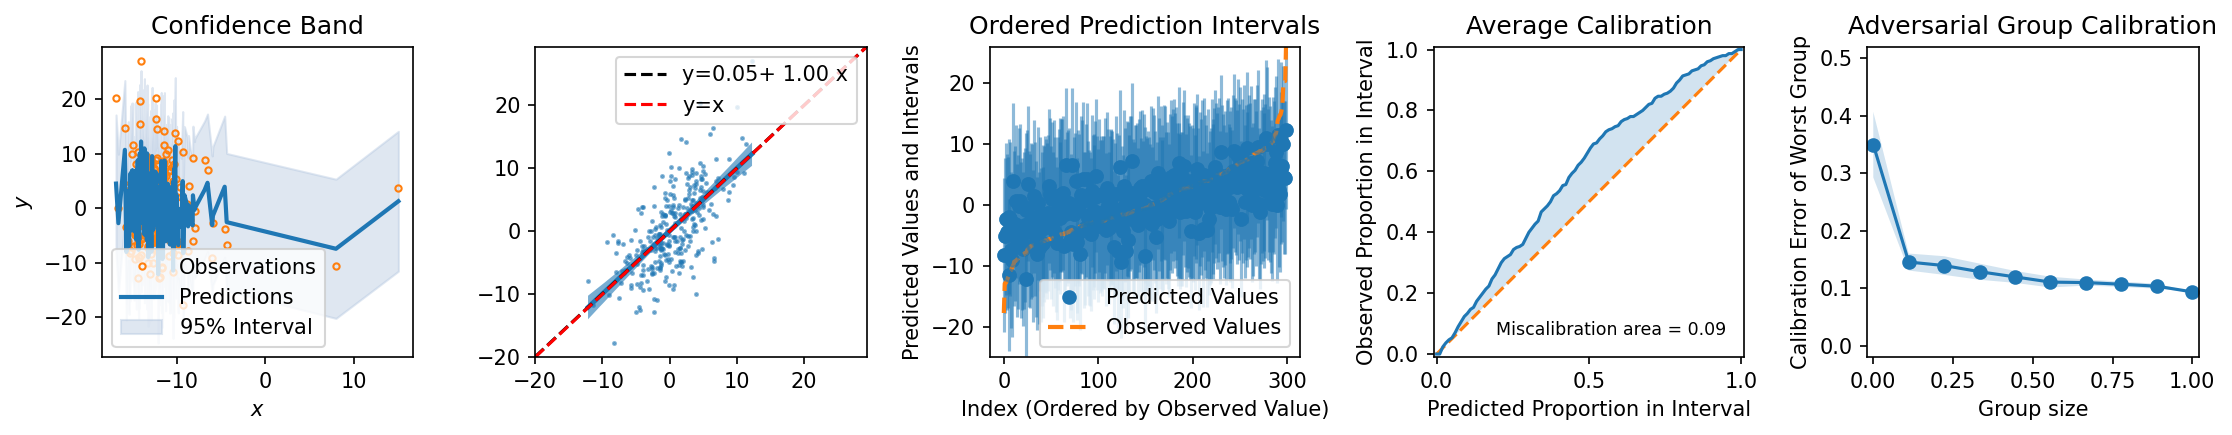

In [68]:
df_tmp = df_trait.sample(n=300, random_state=42)
admix_prs.uct_plot(
    pred_mean=df_tmp["MEAN"].values,
    pred_std=df_tmp["SD"].values + 4,
    y=df_tmp["PHENO_RESID"].values,
    x=df_tmp["PC1"].values,
)

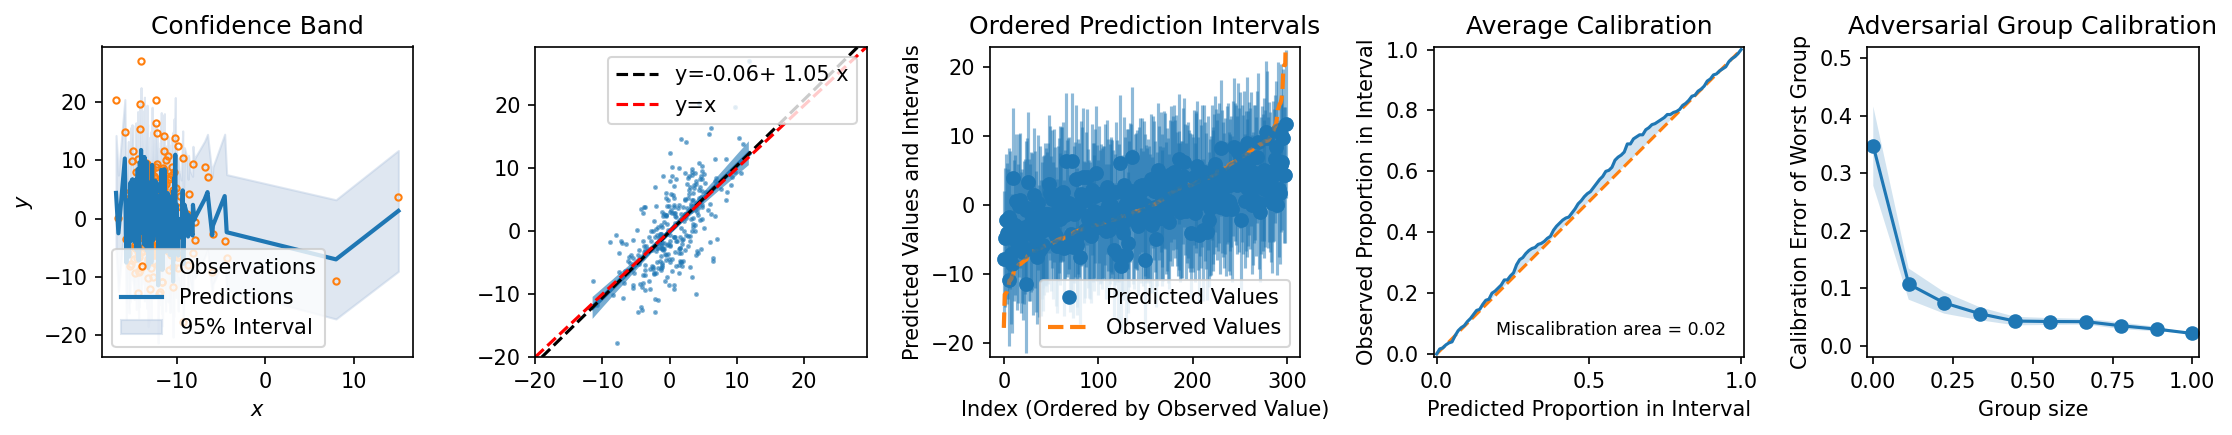

In [50]:
df_calibrated[["PHENO_RESID", "PC1"]] = df_trait[["PHENO_RESID", "PC1"]].reindex(
    df_calibrated.index
)
df_tmp = df_calibrated.sample(n=300, random_state=42)

admix_prs.uct_plot(
    pred_mean=df_tmp["MEAN"].values,
    pred_std=df_tmp["SD"].values,
    y=df_tmp["PHENO_RESID"].values,
    x=df_tmp["PC1"].values,
)

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import numpy as np
import pandas as pd
import pickle
import os
import admix_prs
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import admix
import admix_prs
import statsmodels.api as sm

np.random.seed(1)

In [ ]:
COVAR_PATH = "DATA/covariates.txt"
df_covar = pd.read_csv(COVAR_PATH, sep="\t", index_col=0)

PHENO_PATH = "DATA/all-pheno.csv"
df_pheno = pd.read_csv(PHENO_PATH, index_col=0)

idx = list(set(df_covar.index) & set(df_pheno.index))
df_info = df_pheno.loc[idx].copy()
df_covar = df_covar.loc[idx]

for col in ["deprivation_index", "group"]:
    df_info[col] = df_covar[col]

df_info.index = df_info.index.astype(str) + "_" + df_info.index.astype(str)

# TODO: maybe it is necessary to perform quantile normalization
# df_trait_pheno["REAL"] = admix.data.quantile_normalize(df_trait_pheno["REAL"])

# load trait prediction
for trait in ["ldl_direct", "bmi", "height"]:
    df_prs = pd.read_csv(f"DATA/{trait}.tsv.gz", sep="\t", index_col=0)
    df_info[trait] = admix.data.quantile_normalize(df_info[trait])
    df_info[f"{trait}_PRED_MEAN"] = df_prs["MEAN"].reindex(df_info.index)
    df_info[f"{trait}_PRED_STD"] = df_prs["SD"].reindex(df_info.index)

In [ ]:
df_tmp = df_tmp.sample(n=200, random_state=42)
admix_prs.uct_plot(
    pred_mean=df_tmp[f"{trait}_PRED_MEAN"].values,
    pred_std=df_tmp[f"{trait}_PRED_STD"].values,
    y=df_tmp[trait].values,
    x=df_tmp["PC1"].values,
)